### Von Frey XO sequence converter


In [523]:
library(readr)
library(ggplot2)
library(ggpubr)
#library(ggiraphExtra)
library(dplyr)
library(tidyverse)
library(rstatix)
library(DescTools)

### Define some custom functions

In [524]:
`%notin%` <- Negate(`%in%`)

In [574]:
description <- 'Use this text field to describe the experiment'  # custom title of the project to include on graphs
data_name <- "GE29_Rats_COV"  # data table placed in folder files

data_file <- paste(data_name, 'csv', sep='.')
meta_file <- paste(data_name, 'meta.csv', sep='.')
paw <- 'LEFT' #'RIGHT',  # define paw to use

sex <- "female"  # define sex of animals if needed. Assign "" is sex is not defined
species <- "rats" # define species of animal RATS or MICE
res_file <- paste('result', data_file, sep='.')  # result file

In [593]:
# Folder definitions
main_folder = ""
data_folder <- "files"
par_folder <- "parameters"

sex <- toupper(sex)

## Perform Von Frey Test calculations


In [602]:
XO_file <- paste(species, "final.previous.filaments.XO.csv", sep='.')
stat_file <- paste(species, "observation-statistics.csv", sep='.')

observation_table <- read.csv(file.path(par_folder, stat_file), row.names=1, stringsAsFactors=FALSE)
XO.table <- read.csv(file.path(par_folder, XO_file), row.names=1, stringsAsFactors=FALSE) #, col_types = "nnn")

VonFrey = function(obs='', last=0){
    obs <- toupper(obs)
    res <- 0
    if (obs == '' | last == 0) { return (-2)} 
    else if (obs == 'OOOOO' & last == 5.18) { res <- 15 } 
    else if (obs == 'XXXX' & last == 3.61) { res <- 0.2 }
    else if (length(which(rownames(XO.table) == last)) == 0 | length(which(rownames(observation_table) == obs))== 0) { return (-1)}
    else {
    a <- substr(obs, nchar(obs)-1, nchar(obs)-1)
    prev <- XO.table[which(rownames(XO.table) == last), a]
    dif <- abs(last - prev)
    p50 <- last + dif * observation_table[which(rownames(observation_table) == obs),'STATISTIC']
    res <- (10**p50)/10000
    if (res > 15) { res <- 15 }
    if (res < 0.2) { res <- 0.20 }
    return(as.numeric(sprintf("%.2f", res)))
    }
}
TruncateObservation = function(obs='', met=2){
    obs <- toupper(obs)
    if (obs == '') { return ("") } 
    if (met == 2) { return (obs) }
    if (met == 1) {  # Jenny's short method
    len <- nchar(obs)  
    Xpos <- StrPos(obs, 'X') 
    if (is.na(Xpos)) { return (obs) }   
    obs1 <- substr(obs, Xpos, len)
 
    return (obs1)
    }
}

## Read DATA and META files from *files* folder

In [670]:
x <- read_csv(file.path(data_folder, data_file), col_types = "?ccccciccicn")
meta <- read_csv(file.path(data_folder, meta_file), col_types = "icccc")

In [671]:
x <- x %>% rename_with(toupper)
meta <- meta %>% rename_with(toupper)

# convert key parameters to uppercase
x <- x %>% mutate (SEX = toupper(SEX), 
                   OBSERVATION = toupper(OBSERVATION),
                   PAW = toupper(PAW))

head(x)
head(meta)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>
1/13/22,RAT,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
1/13/22,RAT,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18
1/13/22,RAT,FEMALE,SCRs,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18
1/14/22,RAT,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
1/14/22,RAT,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
1/14/22,RAT,FEMALE,SCRs,A,AC342,7,N,LEFT,0,OOOOXOXXO,4.74


COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<int>,<chr>,<chr>,<chr>,<chr>
1,MBP84_104,PBS,RAT,FEMALE
2,MBP84_104,SCRs,RAT,FEMALE
3,OC_WT,PBS,RAT,FEMALE
4,OC_WT,SCRs,RAT,FEMALE


### filter by specific sex if **sex** is assigned

In [672]:
if (sex != ""){ x <- x %>% filter (SEX == sex) }

### Calculate **Von Frey Test** values

In [673]:
x <- x %>% mutate(RESULT = mapply(VonFrey, OBSERVATION, LAST))

In [674]:
head(x, 10)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1/13/22,RAT,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
1/13/22,RAT,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
1/13/22,RAT,FEMALE,SCRs,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18,11.66
1/14/22,RAT,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
1/14/22,RAT,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34
1/14/22,RAT,FEMALE,SCRs,A,AC342,7,N,LEFT,0,OOOOXOXXO,4.74,9.49
1/13/22,RAT,FEMALE,SCRs,A,AC225,1,L,RIGHT,0,OOOXOOO,5.18,13.85
1/13/22,RAT,FEMALE,SCRs,A,AC226,1,R,RIGHT,0,OOOOO,5.18,15.00
1/13/22,RAT,FEMALE,SCRs,A,AC227,1,N,RIGHT,0,OOOOO,5.18,15.00


### Check for any errors of Von Frey calculations 

In [675]:
x %>% filter(RESULT < 0)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>


### Write results file in *files* folder

In [676]:
write.csv(x, res_file)

### Prepare dataset for ANOVA analysis and plotting

In [757]:
x <- x %>% filter(RESULT > 0)
lp_x_names <- c('SEX', 'GROUP', 'PAW', 'TIMEPOINT', 'RESULT')
lp_meta_names <- c('COMPARISON', 'TREATMENT', 'REFERENCE')

In [758]:
lp <- x %>% 
    select(all_of(lp_x_names)) %>% 
        mutate(DAY = TIMEPOINT, 
               TIMEPOINT = factor(TIMEPOINT),
               GROUP = factor(GROUP),
               ID = row_number()) %>% 
        print

# A tibble: 360 × 7
   SEX    GROUP PAW   TIMEPOINT RESULT   DAY    ID
   <chr>  <fct> <chr> <fct>      <dbl> <int> <int>
 1 FEMALE SCRs  LEFT  0           8.34     0     1
 2 FEMALE SCRs  LEFT  0          15        0     2
 3 FEMALE SCRs  LEFT  0          11.7      0     3
 4 FEMALE SCRs  LEFT  0           8.34     0     4
 5 FEMALE SCRs  LEFT  0           8.34     0     5
 6 FEMALE SCRs  LEFT  0           9.49     0     6
 7 FEMALE SCRs  RIGHT 0          13.8      0     7
 8 FEMALE SCRs  RIGHT 0          15        0     8
 9 FEMALE SCRs  RIGHT 0          15        0     9
10 FEMALE SCRs  RIGHT 0          15        0    10
# … with 350 more rows


In [760]:
print(meta)

# A tibble: 4 × 5
  COMPARISON     TREATMENT REFERENCE SPECIES SEX   
  <chr>          <chr>     <chr>     <chr>   <chr> 
1 MBP84_104-PBS  MBP84_104 PBS       RAT     FEMALE
2 MBP84_104-SCRs MBP84_104 SCRs      RAT     FEMALE
3 OC_WT-PBS      OC_WT     PBS       RAT     FEMALE
4 OC_WT-SCRs     OC_WT     SCRs      RAT     FEMALE


### Set up comparison pairs

In [761]:
meta <- meta %>% mutate(COMPARISON = mapply(sprintf, "%s-%s", TREATMENT, REFERENCE)) %>% print

# A tibble: 4 × 5
  COMPARISON     TREATMENT REFERENCE SPECIES SEX   
  <chr>          <chr>     <chr>     <chr>   <chr> 
1 MBP84_104-PBS  MBP84_104 PBS       RAT     FEMALE
2 MBP84_104-SCRs MBP84_104 SCRs      RAT     FEMALE
3 OC_WT-PBS      OC_WT     PBS       RAT     FEMALE
4 OC_WT-SCRs     OC_WT     SCRs      RAT     FEMALE


In [762]:
if (paw != "") { lp <- lp %>% filter(PAW == paw) }

In [763]:
if(RELATIVE){lp <- lp %>% mutate (RESULT <- 100 * RESULT / 15)}

In [764]:
min_res <- lp %>% select (RESULT) %>% min %>% print
max_res <- lp %>% select (RESULT) %>% max %>% print

[1] 0.98
[1] 15


## Summary statistics
Compute some summary statistics (count, mean and sd) of the variable weight organized by groups:

# Two-way ANOVA

## Summary statistics
Compute the mean and the SD (standard deviation) of the score by groups:

In [765]:
lp_stat <- lp %>%
  group_by(GROUP, TIMEPOINT) %>%
        get_summary_stats(RESULT, type = "mean_sd") %>% print

# A tibble: 30 × 6
   GROUP     TIMEPOINT variable     n  mean    sd
   <fct>     <fct>     <chr>    <dbl> <dbl> <dbl>
 1 COV2      0         RESULT       6 13.6   2.55
 2 COV2      1         RESULT       6  8.20  4.63
 3 COV2      3         RESULT       6  6.35  1.99
 4 COV2      5         RESULT       6  7.79  3.27
 5 COV2      7         RESULT       6 12.2   1.94
 6 COV2      13        RESULT       6  8.00  2.08
 7 MBP84_104 0         RESULT       6 11.8   3.46
 8 MBP84_104 1         RESULT       6  5.08  3.11
 9 MBP84_104 3         RESULT       6  4.93  3.19
10 MBP84_104 5         RESULT       6  6.84  5.14
# … with 20 more rows


## Visualization
Create a box plot of the score by gender levels, colored by education levels:

In [766]:
options(repr.plot.width=15, repr.plot.height=15) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))

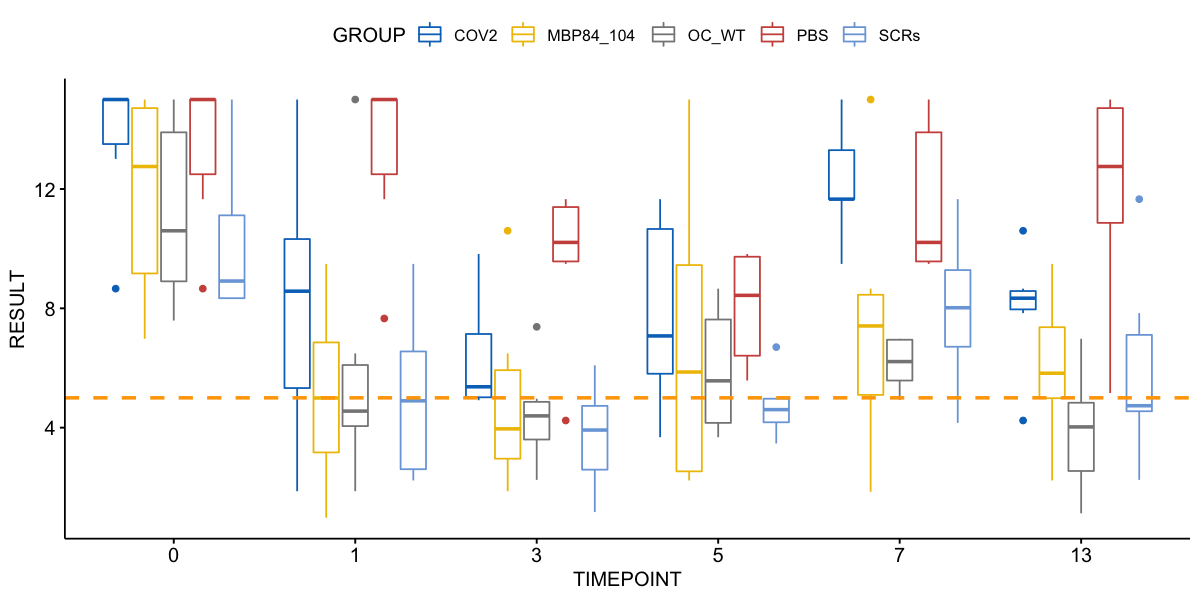

In [767]:
options(repr.plot.width=10, repr.plot.height=5) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))

bxp <- lp %>% ggboxplot(
    x = "TIMEPOINT", y = "RESULT",
    color = "GROUP", 
    palette = "jco") +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1)

plot(bxp)

In [768]:
lp_outs <- lp %>%
  group_by(GROUP, TIMEPOINT) %>%
    identify_outliers(RESULT) %>% print()

lp <- lp %>% anti_join(lp_outs, by = "ID") %>% print()

# A tibble: 12 × 9
   GROUP     TIMEPOINT SEX    PAW   RESULT   DAY    ID is.outlier is.extreme
   <fct>     <fct>     <chr>  <chr>  <dbl> <int> <int> <lgl>      <lgl>     
 1 COV2      0         FEMALE LEFT    8.66     0    39 TRUE       TRUE      
 2 COV2      13        FEMALE LEFT    4.24    13   323 TRUE       TRUE      
 3 COV2      13        FEMALE LEFT   10.6     13   349 TRUE       TRUE      
 4 MBP84_104 3         FEMALE LEFT   10.6      3   137 TRUE       FALSE     
 5 MBP84_104 7         FEMALE LEFT   15        7   279 TRUE       FALSE     
 6 OC_WT     1         FEMALE LEFT   15        1    87 TRUE       TRUE      
 7 OC_WT     3         FEMALE LEFT    7.38     3   147 TRUE       FALSE     
 8 PBS       0         FEMALE LEFT    8.66     0    52 TRUE       FALSE     
 9 PBS       1         FEMALE LEFT    7.66     1   112 TRUE       FALSE     
10 PBS       3         FEMALE LEFT    4.24     3   174 TRUE       FALSE     
11 SCRs      5         FEMALE LEFT    6.7      5   183 TR

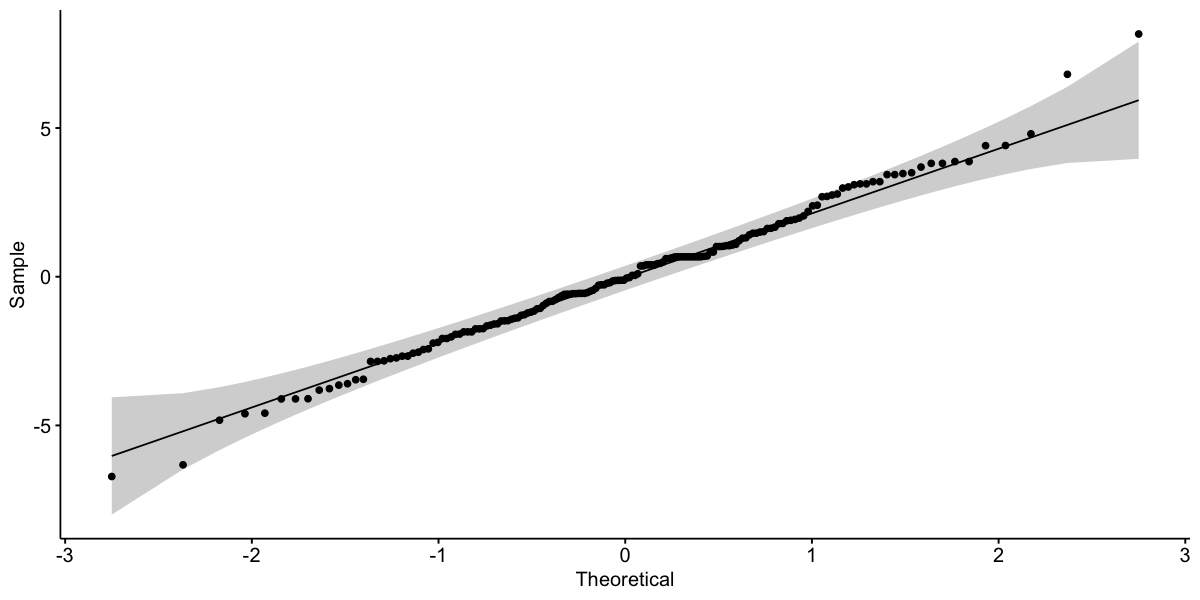

In [769]:
# Build the linear model
model  <- lm(RESULT ~ GROUP * TIMEPOINT, data = lp)
# Create a QQ plot of residuals
model %>% residuals %>% ggqqplot

In [770]:
# Compute Shapiro-Wilk test of normality
model %>% residuals %>% shapiro_test

variable,statistic,p.value
<chr>,<dbl>,<dbl>
.,0.9918959,0.4648291


In [771]:
lp %>% group_by(GROUP, TIMEPOINT) %>% shapiro_test(RESULT) %>% print

# A tibble: 30 × 5
   GROUP     TIMEPOINT variable statistic        p
   <fct>     <fct>     <chr>        <dbl>    <dbl>
 1 COV2      0         RESULT       0.552 0.000131
 2 COV2      1         RESULT       0.989 0.986   
 3 COV2      3         RESULT       0.788 0.0462  
 4 COV2      5         RESULT       0.902 0.383   
 5 COV2      7         RESULT       0.920 0.509   
 6 COV2      13        RESULT       0.922 0.551   
 7 MBP84_104 0         RESULT       0.870 0.226   
 8 MBP84_104 1         RESULT       0.965 0.856   
 9 MBP84_104 3         RESULT       0.958 0.793   
10 MBP84_104 5         RESULT       0.880 0.267   
# … with 20 more rows


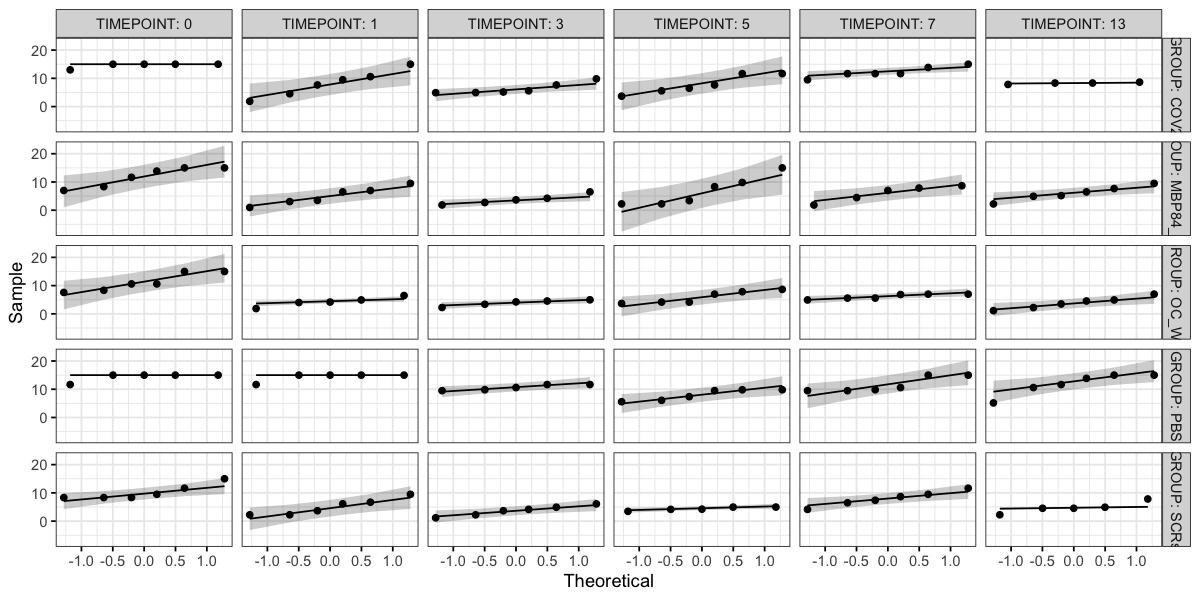

In [750]:
ggqqplot(lp, "RESULT", ggtheme = theme_bw()) +
  facet_grid( GROUP ~ TIMEPOINT, labeller = "label_both")

In [751]:
lp %>% group_by(TIMEPOINT) %>% anova_test(RESULT ~ GROUP)

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()



,TIMEPOINT,Effect,DFn,DFd,F,p,p<.05,ges
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0,GROUP,4,23,2.990,4.00e-02,*,0.342
2,1,GROUP,4,23,9.433,1.15e-04,*,0.621
3,3,GROUP,4,22,17.744,1.22e-06,*,0.763
4,5,GROUP,4,24,1.278,3.06e-01,,0.176
5,7,GROUP,4,24,9.847,7.34e-05,*,0.621
6,13,GROUP,4,22,9.377,1.40e-04,*,0.630


In [752]:
# Group data for anova
lp %>%
  group_by(TIMEPOINT) %>%
      anova_test(RESULT ~ GROUP, error = model)

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()



,TIMEPOINT,Effect,DFn,DFd,F,p,p<.05,ges
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0,GROUP,4,138,3.082,1.80e-02,*,0.082
2,1,GROUP,4,138,13.292,3.46e-09,*,0.278
3,3,GROUP,4,138,6.833,4.77e-05,*,0.165
4,5,GROUP,4,138,1.821,1.28e-01,,0.050
5,7,GROUP,4,138,7.557,1.56e-05,*,0.180
6,13,GROUP,4,138,8.858,2.14e-06,*,0.204


In [753]:
library(emmeans)
pwc <- lp %>% 
  group_by(TIMEPOINT) %>%
      emmeans_test(RESULT ~ GROUP, model = model, 
                   #comparisons = list(c("MBP84_104", "PBS"), c("OC_WT", "PBS"), c("MBP84_104", "SCRs"), c("OC_WT", "SCRs")),
                   p.adjust.method = "bonferroni") %>% print

# A tibble: 60 × 10
   TIMEPOINT term  .y.    group1    group2       df statistic       p  p.adj
 * <chr>     <chr> <chr>  <chr>     <chr>     <dbl>     <dbl>   <dbl>  <dbl>
 1 0         GROUP RESULT COV2      MBP84_104   138     1.78  0.0765  0.765 
 2 0         GROUP RESULT COV2      OC_WT       138     2.18  0.0311  0.311 
 3 0         GROUP RESULT COV2      PBS         138     0.165 0.869   1     
 4 0         GROUP RESULT COV2      SCRs        138     2.81  0.00565 0.0565
 5 0         GROUP RESULT MBP84_104 OC_WT       138     0.413 0.681   1     
 6 0         GROUP RESULT MBP84_104 PBS         138    -1.61  0.109   1     
 7 0         GROUP RESULT MBP84_104 SCRs        138     1.08  0.283   1     
 8 0         GROUP RESULT OC_WT     PBS         138    -2.01  0.0468  0.468 
 9 0         GROUP RESULT OC_WT     SCRs        138     0.665 0.507   1     
10 0         GROUP RESULT PBS       SCRs        138     2.64  0.00926 0.0926
# … with 50 more rows, and 1 more variable: p.adj.signif

In [754]:
pwc <- pwc %>% mutate(TIMEPOINT = as.integer(TIMEPOINT)) %>% add_xy_position(x = "TIMEPOINT")
pwc.filtered <- pwc %>% filter((group1 == "OC_WT" & group2 == "PBS") )#| ((group1 == "RA" & group2 == "RB")))

pwc.filtered$p.format <- p_format(pwc.filtered$p, accuracy = 0.0001, leading.zero = TRUE)
pwc$p.format <- p_format(pwc$p, accuracy = 0.0001, leading.zero = FALSE)

head(pwc)
pwc.filtered

TIMEPOINT,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,y.position,groups,x,xmin,xmax,p.format
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>,<dbl>,<chr>
0,GROUP,RESULT,COV2,MBP84_104,138,1.7844931,0.076540747,0.76540747,ns,16.20360,"COV2 , MBP84_104",1,0.68,0.84,.07654
0,GROUP,RESULT,COV2,OC_WT,138,2.1779280,0.031110544,0.31110544,ns,17.54093,"COV2 , OC_WT",1,0.68,1.00,.03111
0,GROUP,RESULT,COV2,PBS,138,0.1649271,0.869242745,1.00000000,ns,18.87827,"COV2, PBS",1,0.68,1.16,.86924
0,GROUP,RESULT,COV2,SCRs,138,2.8116772,0.005646762,0.05646762,ns,20.21560,"COV2, SCRs",1,0.68,1.32,.00565
0,GROUP,RESULT,MBP84_104,OC_WT,138,0.4126380,0.680512217,1.00000000,ns,21.55293,"MBP84_104, OC_WT",1,0.84,1.00,.68051
0,GROUP,RESULT,MBP84_104,PBS,138,-1.6122324,0.109196036,1.00000000,ns,22.89027,"MBP84_104, PBS",1,0.84,1.16,.1092


TIMEPOINT,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,y.position,groups,x,xmin,xmax,p.format
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>,<dbl>,<chr>
0,GROUP,RESULT,OC_WT,PBS,138,-2.005667,4.684688e-02,4.684688e-01,ns,25.56493,"OC_WT, PBS",1,1,1.16,0.04685
1,GROUP,RESULT,OC_WT,PBS,138,-6.130400,8.665657e-09,8.665657e-08,****,25.56493,"OC_WT, PBS",2,2,2.16,<0.0001
13,GROUP,RESULT,OC_WT,PBS,138,-5.347565,3.603608e-07,3.603608e-06,****,22.22493,"OC_WT, PBS",6,6,6.16,<0.0001
3,GROUP,RESULT,OC_WT,PBS,138,-4.132950,6.181152e-05,6.181152e-04,***,25.56493,"OC_WT, PBS",3,3,3.16,<0.0001
5,GROUP,RESULT,OC_WT,PBS,138,-1.415237,1.592518e-01,1.000000e+00,ns,25.56493,"OC_WT, PBS",4,4,4.16,0.15925
7,GROUP,RESULT,OC_WT,PBS,138,-3.624523,4.061099e-04,4.061099e-03,**,25.56493,"OC_WT, PBS",5,5,5.16,0.00041


<ScaleContinuousPosition>
 Range:  
 Limits:    0 --    1

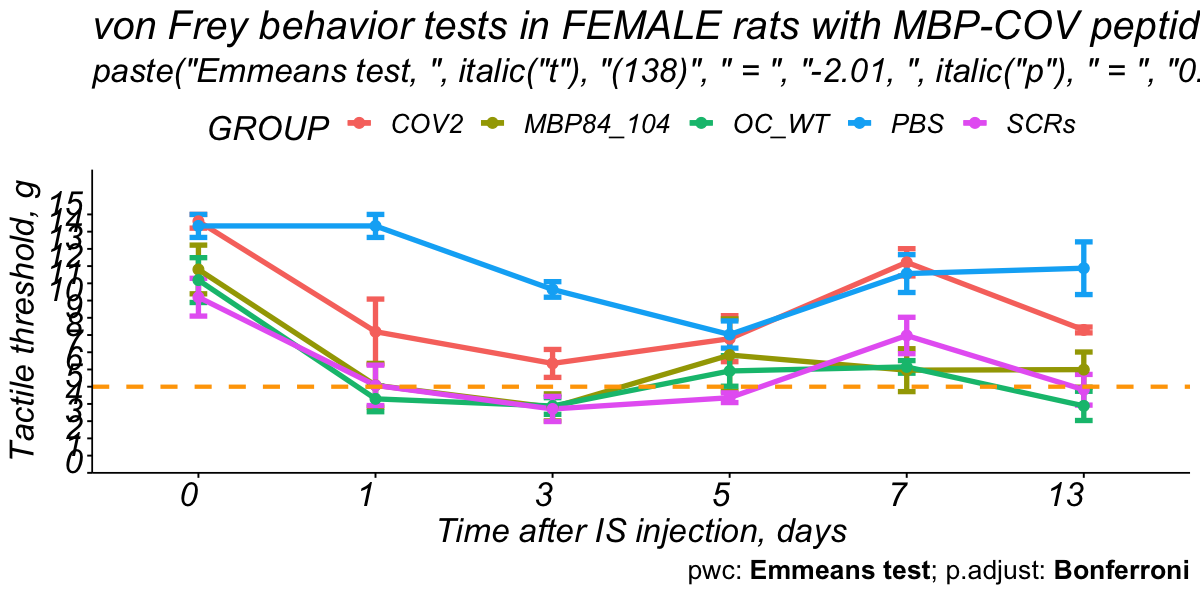

In [793]:
library(ggprism)
# Visualization: box plots with p-values
y_min <- round(min(lp$RESULT))
x_max <- 15 #round(max(lp$TIMEPOINT)) + 1

p <- ggline(
            lp, #lp, 
            x = "TIMEPOINT",
            y = "RESULT", 
            size = 1.5,            
            color = "GROUP",
            linetype = "solid",
            ylim = c(y_min-1, max_res+1),
            add = c("mean_se" ), #"boxplot", "violin","jitter", 
            add.params = list(width = 0.1, shape = 15)#,
            #palette = c("magenta", "purple") #, "green", "navy")
            )+   #  geom_boxplot(width = 2, alpha=0.2) +
   stat_pvalue_manual(
   # add_pvalue(
        pwc.filtered, 
           label = "p = {p.format}", #paste("p = {p.format}", "{p.signif}", sep = ', '),
            size = 6,
            position = position_dodge(0.2)
            ) +

    labs(
            subtitle = get_test_label(pwc.filtered, detailed = TRUE),
            caption = get_pwc_label(pwc.filtered) #aov
        ) +

    scale_fill_brewer(palette="Set1")+
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle(sprintf("von Frey behavior tests in %s %s with %s, %s paw", sex, species, anal_name, paw_side)) +
#    scale_shape_manual(values=c(18, 16, 17, 15)) +
    theme(text = element_text(size=20, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic"),
    axis.text.x = element_text(hjust=1)) +
    geom_hline(yintercept=5, linetype="dashed", 
                color = "orange", size=1.2) +
    #geom_hline(yintercept=c(0, 1,2,3,4), linetype="dashed", 
    #            color = "gray", size=0.3) +
    scale_y_continuous( breaks=0:15*1, expand = expansion(mult = c(0, 0.1))  )#+# +  #, trans = 'log2'
    scale_x_continuous(breaks=0:15*1) #+  
    #scale_x_discrete(drop=FALSE,  breaks=c("0", "1", "2", "3", "5", "6", "7", "8", "9", "10", "11", "12", "13"))

plot(p)

In [715]:
pdf(sprintf("vonFrey %s %s %s.pdf", anal_name, anal_date, paw_side), width = 20, height = 20)
plot(p)
dev.off()

Warning message:
“position_dodge requires non-overlapping x intervals”


pdf 
  2

In [637]:
lp %>% head

SEX,GROUP,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT,DAY
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>
FEMALE,SCRs,LEFT,0,OOOOXXOXO,4.74,8.34,0
FEMALE,SCRs,LEFT,0,OOOOO,5.18,15.00,0
FEMALE,SCRs,LEFT,0,OOOOXOXOX,5.18,11.66,0
FEMALE,SCRs,LEFT,0,OOOOXXOXO,4.74,8.34,0
FEMALE,SCRs,LEFT,0,OOOOXXOXO,4.74,8.34,0
FEMALE,SCRs,LEFT,0,OOOOXOXXO,4.74,9.49,0


In [488]:
head(lp_stat)

GROUP,TIMEPOINT,variable,n,mean,sd
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
COV2,0,RESULT,6,13.612,2.553
COV2,1,RESULT,6,8.195,4.634
COV2,3,RESULT,6,6.352,1.986
COV2,5,RESULT,6,7.788,3.269
COV2,7,RESULT,6,12.220,1.938
COV2,13,RESULT,6,8.003,2.078


In [489]:
lp$TIMEPOINT <- as.numeric(lp$TIMEPOINT)
head(lp)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT,DAY
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>
1/13/22,RAT,FEMALE,SCRs,A,AC225,1,L,LEFT,1,OOOOXXOXO,4.74,8.34,0
1/13/22,RAT,FEMALE,SCRs,A,AC226,1,R,LEFT,1,OOOOO,5.18,15.00,0
1/13/22,RAT,FEMALE,SCRs,A,AC227,1,N,LEFT,1,OOOOXOXOX,5.18,11.66,0
1/14/22,RAT,FEMALE,SCRs,A,AC340,7,L,LEFT,1,OOOOXXOXO,4.74,8.34,0
1/14/22,RAT,FEMALE,SCRs,A,AC341,7,R,LEFT,1,OOOOXXOXO,4.74,8.34,0
1/14/22,RAT,FEMALE,SCRs,A,AC342,7,N,LEFT,1,OOOOXOXXO,4.74,9.49,0


In [807]:
meta
nrow(meta)

COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<chr>,<chr>,<chr>,<chr>,<chr>
MBP84_104-PBS,MBP84_104,PBS,RAT,FEMALE
MBP84_104-SCRs,MBP84_104,SCRs,RAT,FEMALE
OC_WT-PBS,OC_WT,PBS,RAT,FEMALE
OC_WT-SCRs,OC_WT,SCRs,RAT,FEMALE


[1] 4

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



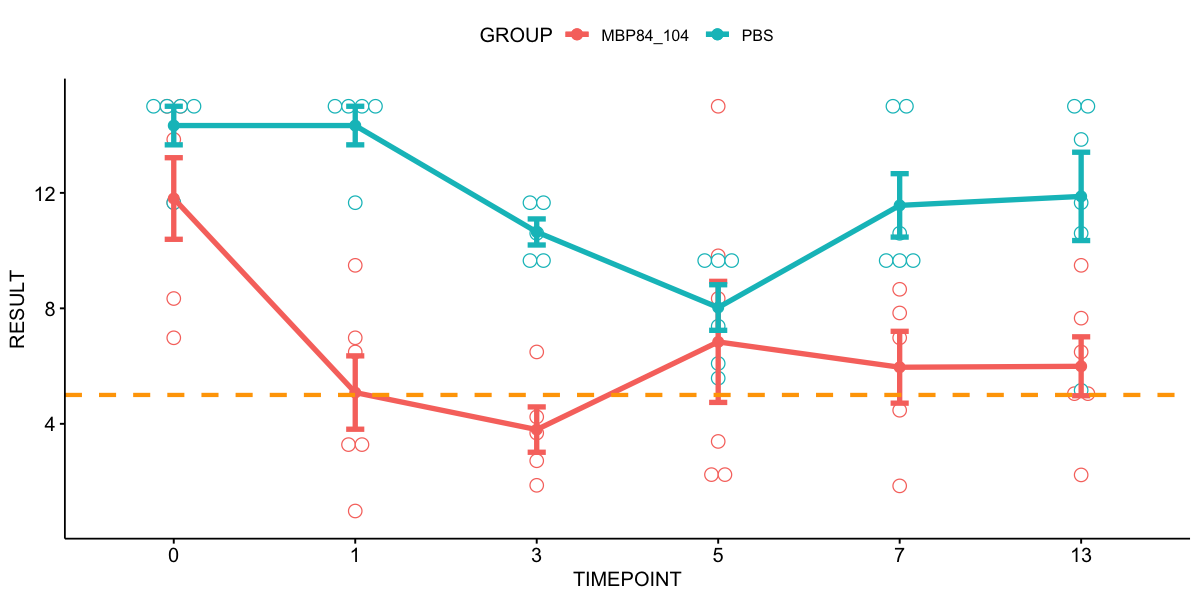

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



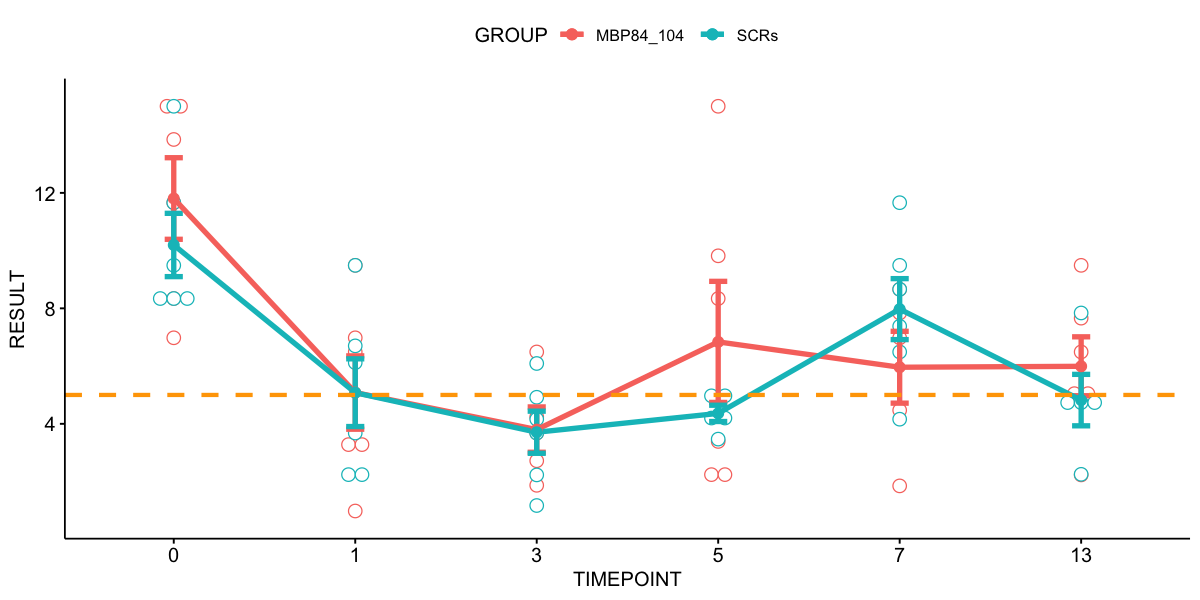

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



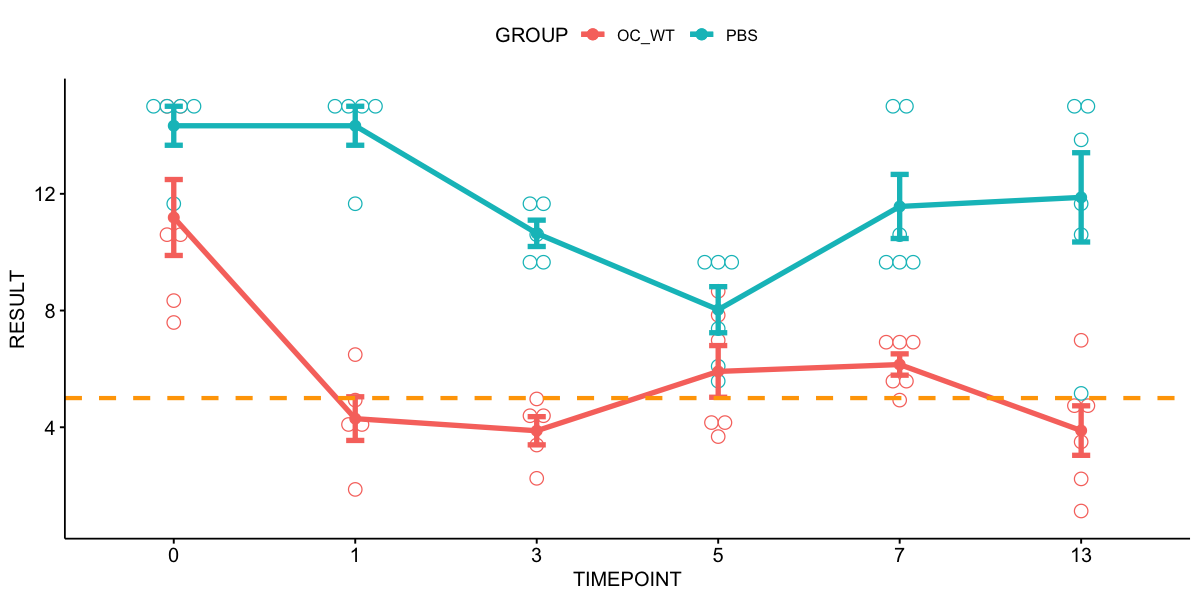

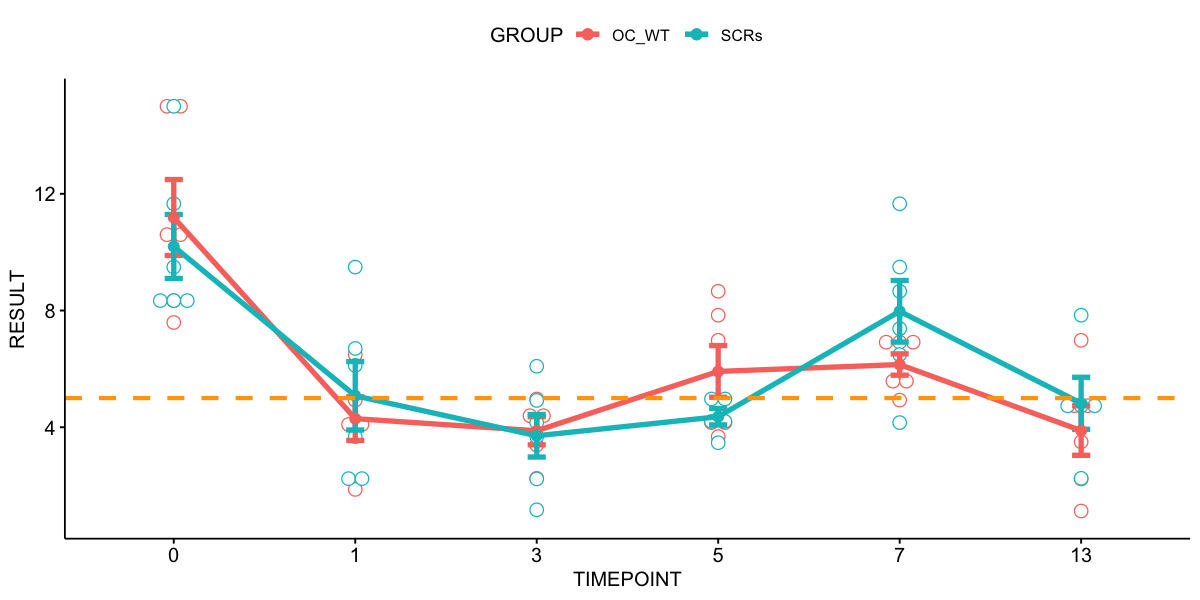

In [812]:
for (i in 1:nrow(meta)){

lp1 <- lp %>% filter (GROUP == meta$TREATMENT[i] | GROUP == meta$REFERENCE[i])
    
pp <- ggline(lp1, x = "TIMEPOINT", y = "RESULT", color = "GROUP",
        add = c("mean_se", "dotplot"),
        size = 1.5, fill="GROUP",
        linetype = "solid") #+ scale_fill_brewer(palette="Dark2")
pp <- pp + geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1.2)
#pp <- pp + geom_dotplot(binaxis='y', stackdir='center', stackratio=1.5, dotsize=0.5) #, fill = "GROUP")
plot(pp)
}